## Проект по A/B тестированию


Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?
___

### Решение:

In [2]:
# Подгружаем необходимые библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import pingouin as pg
from scipy.stats import norm

In [3]:
# Загружаем данные в датафрейм
df_ab_test = pd.read_csv('Проект_АВ_тест.csv', sep=';')

Посмотрим на получившийся датафрейм и проверим, нет ли пропусков дубликатов, а так же посмотрим описательную статистику revenue.

In [4]:
df_ab_test.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [5]:
# Посмотрим на пропуски и тип данных
df_ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [6]:
# Проверим на наличие дубликатов
df_ab_test.loc[df_ab_test.duplicated()]

,user_id,revenue,testgroup


In [7]:
# Посомотрим описательную статистику
df_ab_test.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

Дубликатов и пропусков нет.
Давайте определим, какая группа контрольная, какая тестовая и посмотрим на значения каждой из них

In [8]:
df_ab_test.loc[df_ab_test.testgroup == 'a'].shape

(202103, 3)

In [9]:
df_ab_test.loc[df_ab_test.testgroup == 'b'].shape

(202667, 3)

Опираясь на условие, теперь мы знаем, что группа 'а' - контрольная, а группа 'b' - тестовая

In [10]:
# Разделим данные по группам
control_group = df_ab_test.loc[df_ab_test.testgroup == 'a']
test_group = df_ab_test.loc[df_ab_test.testgroup == 'b']

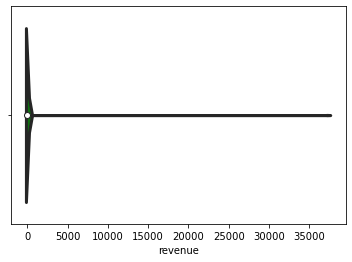

In [11]:
# Посмотрим на распределение в группах
sns.violinplot(x=control_group.revenue,
               color='green',
               edgecolor='grey',
               linewidth=3);

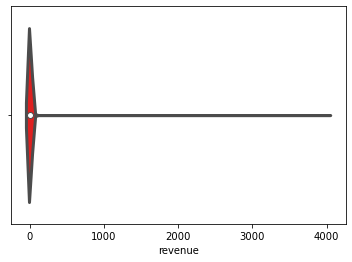

In [12]:
sns.violinplot(x=test_group.revenue,
               color='red',
               edgecolor='grey',
               linewidth=3);

Судя по графикам видно, что медианые значения у нас находятся около нуля. Это не удивительно, так как в метрике мы считаем всех кто заплатил и кто нет, соответсвенно, неплатящих чаще больше, чем платящих. При этом интересный факт, что в группах максимальные значения сильно разнятся. В которольной значения выше 37000, а в тестовой они доходят только до ~4000.

Посмотрим как же распределились значения выше медианы. И проверим распределение на нормальность.

In [13]:
control_group.revenue.quantile([0.25, 0.5, 0.75, 0.95, 0.995])

0.250      0.0
0.500      0.0
0.750      0.0
0.950      0.0
0.995    307.0
Name: revenue, dtype: float64

In [14]:
test_group.revenue.quantile([0.25, 0.5, 0.75, 0.90, 0.95, 0.995])

0.250       0.00
0.500       0.00
0.750       0.00
0.900       0.00
0.950       0.00
0.995    2890.67
Name: revenue, dtype: float64

In [15]:
# Проверим данные на нормальность распределения 
pg.normality(df_ab_test, dv='revenue', group='testgroup', method='normaltest')

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


Как и предполагалось - в обоих группах большинство пользователей не конвертируются в покупку, платящие пользователи составляют менее 1% от общего числа пользователей.
Интересный факт, что в тестовой группе выручка 99.5 процентиля равна 2890.67, а в контрольной - равна 307, хотя максимальное ее значение привышает 37000.

Если учесть, что по результатам теста распределение не нормальное, платящих пользоваталей менее 1% , можем сделать вывод , что выделить какие то действительные различия по ментрике ARPU карайне тяжело. И так как для нас все же важны платящие пользователи, то для репрезентативности будем использовать метрику ARPPU.

### Посчитаем ARPPU для каждой из групп.
Для этого отберем пользователей, которые соверщали покупки (revenue > 0)

In [16]:
# Отбираем пользователей по группам
control_pay = control_group.loc[control_group.revenue > 0]
test_pay = test_group.loc[test_group.revenue > 0]

In [17]:
arppu_control = round((control_pay.revenue.sum() / control_pay.user_id.nunique()), 2)
arppu_test = round((test_pay.revenue.sum() / test_pay.user_id.nunique()), 2)

In [18]:
arppu_control, arppu_test

(2664.0, 3003.66)

In [19]:
# Сравним ARPPU групп между собой
round(((arppu_test - arppu_control) / arppu_control * 100), 2)

12.75

По расчетам ARPPU тестовой группы больше на ~ 12.75%. Но прежде чем делать выводы, давайте проверим, является ли разница статистически значимой. Что бы определить метод проверим распределение на нормальность, а так же посмотрим как распределились значения

In [39]:
# Проверим распределение на нормальность:
pg.normality(df_ab_test.loc[df_ab_test.revenue > 0], dv='revenue', group='testgroup', method='normaltest')

,W,pval,normal
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


In [42]:
# Проверим гомоскедастичность дисперсий с помощью критерия Левена
pg.homoscedasticity(data=df_ab_test.loc[df_ab_test.revenue > 0], dv='revenue', group='testgroup')

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


In [41]:
df_ab_test.loc[df_ab_test.revenue > 0]

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a
...,...,...,...
404315,404316,262,a
404525,404526,3120,b
404543,404544,369,a
404602,404603,251,a


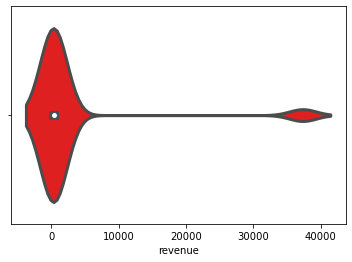

In [21]:
# Посмотрим на распределение контрольной группы платящих пользователей
sns.violinplot(x=control_pay.revenue,
               color='red',
               linewidth=3);

In [27]:
control_pay.revenue.quantile([0.25, 0.5, 0.75, 0.90, 0.95])

0.25      257.00
0.50      311.00
0.75      361.00
0.90      393.30
0.95    37299.65
Name: revenue, dtype: float64

Видно, что большинство позьзователей совершили покупку до 400х рублей и ~ 5% на сумму больще 37000.  

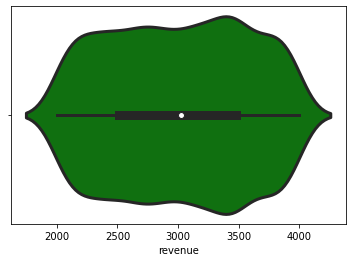

In [45]:
# Посмотрим на распределение тестовой группы платящих пользователей
sns.violinplot(x=test_pay.revenue,
               color='green',
               edgecolor='grey',
               linewidth=3);

In [46]:
test_pay.revenue.quantile([0.25, 0.5, 0.75, 0.90, 0.95])

0.25    2513.0
0.50    3022.0
0.75    3478.0
0.90    3795.8
0.95    3891.8
Name: revenue, dtype: float64

Значения распределилилсь достаточно равномерно. Нет выбросов.


Определимся с выбором метода. 
- Отсутсвует нормальность распределения и гомоскедастичность дисперсий, что влияет на результат t-test'a, а значет его в данном случае лучше не применять.
- У нас есть 2 выборки, и данные непараметрические, потому мы будем использовать bootstrap, как альтернативу U-критерия Манна-Уитни, что бы было проще объяснить результат и сформулировать нулевую гипотезу.

Сформулируем гипотезы:

H0 - среднее значение выручки платящего пользователя тестовой группы не отличается от среднего значения выручки платящего пользователя контрольной группы

Н1 - среднее значегие выручки платящего пользователя тестовой группы отличается от среднего значения выручки платящего пользователя контрольной группы

In [47]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it=1000, 
    statistic=np.mean,
    bootstrap_conf_level=0.95
):
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values

        '''mean() - применяем статистику'''
        boot_data.append(statistic(samples_1) - statistic(samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    '''Визуализация '''
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

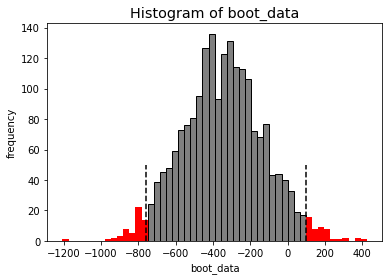

In [48]:
# Применим функцию bootstrap'a
booted_data = get_bootstrap(control_pay['revenue'], test_pay['revenue'], boot_it=2000)

In [49]:
booted_data["p_value"]

0.11004352175280611

In [50]:
booted_data["quants"]

,0
0.025,-759.716779
0.975,97.203877


По результатам теста - 0 входит в доверительный интервал и значение p.val > 0.05, следовательно причин отклонять нулевую гипотезу у нас нет.

___

## Итоговый вывод:
- Для оценки статистической значимости различий в группах лучше всего использовать метрику ARPPU, так как пользователей не совершавщих покупку слишком много. 
- Опираясь на тип наших данных, для стат теста мы использовали метод bootsprap, отобрав из выборок данные только по платившим пользователям. По результатам теста мы подтвердили нулевую гипотезу, о то что различий между группами не обнаружено, однако, судя по распределению выборок в тестовой группе основная часть пользователей приносит больше выручки чем в контрольной, где только ~5% платящих пользователей совершали большие покупки. Это значит, что в случае, если эти пользователи перестанут покупать, есть риск сильно потерять в выручке. Потому более логично использовать новый набор предложений.